<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Guided Practice with Topic Modeling and LDA

_Authors: Dave Yerrington (SF)_

---

> **Note: this lab is intended to be a guided lab with the instructor.**

In practice it would be a very rare to need to build an unsupervised topic model like LDA from scratch. Lucky for us, sklearn comes with LDA topic modeling functionality. Another popular LDA module which we will explore in this lab is from the `gensim` package. 

Let's explore a brief walkthrough of LDA and topic modeling using gensim. We will work with a small collection of documents represented as a list.

### 1. Load the packages and create the small "documents".

You may need to install the gensim package with `pip` or `conda`.

In [4]:
# !pip install gensim

In [3]:
from gensim import corpora, models, matutils
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
import pandas as pd


doc_a = "Brocolli is good to eat. My brother likes to eat good brocolli, but not my mother."
doc_b = "My mother spends a lot of time driving my brother around to baseball practice."
doc_c = "Some health experts suggest that driving may cause increased tension and blood pressure."
doc_d = "I often feel pressure to perform well at school, but my mother never seems to drive my brother to do better."
doc_e = "Health professionals say that brocolli is good for your health."

# compile sample documents into a list
documents = [doc_a, doc_b, doc_c, doc_d, doc_e]
df        = pd.DataFrame(documents, columns=['text'])

In [5]:
df

,text
0,Brocolli is good to eat. My brother likes to e...
1,My mother spends a lot of time driving my brot...
2,Some health experts suggest that driving may c...
3,I often feel pressure to perform well at schoo...
4,Health professionals say that brocolli is good...


#  
#  
### 2. Load stop words either from NLTK or sklearn

In [6]:
from nltk.corpus import stopwords
import nltk
import numpy as np

nltk.download('stopwords')
nltk_stops = stopwords.words()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/edoardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
for word in np.random.choice(nltk_stops,20):
    print(word)

habría
v
tidakkah
түге
تينك
more
राख्छ
vostra
sangatlah
here
apakah
niin
xanım
itt
joista
waren
كأنما
houvéssemos
آه
dus


In [9]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

custom_stop_words = list(ENGLISH_STOP_WORDS)

# You can of course add your own custom stopwords
custom_stop_words.append('mother')
custom_stop_words.append('brother')

#  
### 3. Use CountVectorizer to transform our text, taking out the stopwords.

In [10]:
vectorizer = CountVectorizer(stop_words=custom_stop_words)
X = vectorizer.fit_transform(df['text'])

#  
### 4. Extract the tokens that remain after stopword removal.

The `.vocabulary_` attribute of the vectorizer contains a dictionary of terms. There is also the built-in function `.get_feature_names()` which will extract the column names.

In [11]:
vectorizer.vocabulary_

{'brocolli': 3,
 'good': 10,
 'eat': 7,
 'likes': 13,
 'spends': 21,
 'lot': 14,
 'time': 24,
 'driving': 6,
 'baseball': 0,
 'practice': 16,
 'health': 11,
 'experts': 8,
 'suggest': 22,
 'cause': 4,
 'increased': 12,
 'tension': 23,
 'blood': 2,
 'pressure': 17,
 'feel': 9,
 'perform': 15,
 'school': 20,
 'drive': 5,
 'better': 1,
 'professionals': 18,
 'say': 19}

In [12]:
vectorizer.get_feature_names()

['baseball',
 'better',
 'blood',
 'brocolli',
 'cause',
 'drive',
 'driving',
 'eat',
 'experts',
 'feel',
 'good',
 'health',
 'increased',
 'likes',
 'lot',
 'perform',
 'practice',
 'pressure',
 'professionals',
 'say',
 'school',
 'spends',
 'suggest',
 'tension',
 'time']

#  
# TODO: EXPLAIN SPARSE vs. DENSE MATRIX

#  
### 5. Get counts of tokens.

Convert the matrix from the vectorizer to a dense matrix, then sum by column to get the counts per term.

In [13]:
docs = pd.DataFrame(X.todense(), 
                    columns=vectorizer.get_feature_names())
docs.sum()

baseball         1
better           1
blood            1
brocolli         3
cause            1
drive            1
driving          2
eat              2
experts          1
feel             1
good             3
health           3
increased        1
likes            1
lot              1
perform          1
practice         1
pressure         2
professionals    1
say              1
school           1
spends           1
suggest          1
tension          1
time             1
dtype: int64

#  
### 6. Setup the vocabulary dictionary

First we need to setup the vocabulary.  Gensim's LDA expects our vocabulary to be in a format where the dictionary keys are the column indices and the values are the words themselves.

Create this dictionary below.

In [15]:
# This is the fastest way to swap a dictionary key / value order.  
# This is the format gensim LDA expects it's vocabulary.
vocab = {v: k for k, v in vectorizer.vocabulary_.items()}
vocab

{3: 'brocolli',
 10: 'good',
 7: 'eat',
 13: 'likes',
 21: 'spends',
 14: 'lot',
 24: 'time',
 6: 'driving',
 0: 'baseball',
 16: 'practice',
 11: 'health',
 8: 'experts',
 22: 'suggest',
 4: 'cause',
 12: 'increased',
 23: 'tension',
 2: 'blood',
 17: 'pressure',
 9: 'feel',
 15: 'perform',
 20: 'school',
 5: 'drive',
 1: 'better',
 18: 'professionals',
 19: 'say'}

#  
### 7. Create a token to id mapping with gensim's `corpora.Dictionary`

This dictionary class is a more standard way to work with with gensim models. There are a few standard steps we should go through:

**7.1. Count the frequency of words.**

We can do this easily with the python `defaultdict(int)`, which doesn't require us to already have the key in the dictionary to be able to add to it:

```python
frequency = defaultdict(int)

for text in documents:
    for token in text.split():
        frequency[token] += 1
```




In [16]:
frequency = defaultdict(int)

for text in documents:
    for token in text.split():
        frequency[token] += 1
        
frequency

defaultdict(int,
            {'Brocolli': 1,
             'is': 2,
             'good': 3,
             'to': 6,
             'eat.': 1,
             'My': 2,
             'brother': 3,
             'likes': 1,
             'eat': 1,
             'brocolli,': 1,
             'but': 2,
             'not': 1,
             'my': 4,
             'mother.': 1,
             'mother': 2,
             'spends': 1,
             'a': 1,
             'lot': 1,
             'of': 1,
             'time': 1,
             'driving': 2,
             'around': 1,
             'baseball': 1,
             'practice.': 1,
             'Some': 1,
             'health': 1,
             'experts': 1,
             'suggest': 1,
             'that': 2,
             'may': 1,
             'cause': 1,
             'increased': 1,
             'tension': 1,
             'and': 1,
             'blood': 1,
             'pressure.': 1,
             'I': 1,
             'often': 1,
             'feel': 1,
           

**7.2 Remove any words that only appear once, or appear in the stopwords.**

Iterate through the documents and only keep useful words/tokens.

In [17]:
texts = [[token for token in text.split() if frequency[token] > 1 and token not in nltk_stops]
          for text in documents]

texts

[['good', 'My', 'brother', 'good'],
 ['My', 'mother', 'driving', 'brother'],
 ['driving'],
 ['mother', 'brother'],
 ['good']]

**7.3 Create the `corpora.Dictionary` object with the retained tokens.**

In [18]:
# Create gensim dictionary object
dictionary = corpora.Dictionary(texts)
dictionary

**7.4 Use the `dictionary.doc2bow()` function to convert the texts to bag-of-word representations.**

In [19]:
# Create corpus matrix
corpus = [dictionary.doc2bow(text) for text in texts]
corpus

[[(0, 1), (1, 1), (2, 2)],
 [(0, 1), (1, 1), (3, 1), (4, 1)],
 [(3, 1)],
 [(1, 1), (4, 1)],
 [(2, 1)]]

**Why should we use this process?**

The main advantage is that this dictionary object has quick helper functions.

However, there are also some major performance advantages if you ever want to save your model to a file, then load it at a later time.  Tokenizations can take a while to be computed, especially when your text files are quite large. You can save these post-computed dictionary items to file, then load them from disk later which is quite a bit faster.  Also, it's possible to add new documents to your corpus without having to re-tokenize your entire set.  This is great for online systems that can take new documents on demmand.  

As you work with larger datasets with text, this is a much better way to handle LDA and other Gensim models from a performance point of view.

#  
### 8. Set up the LDA model

We can create the gensim LDA model object like so:

```python
lda = models.LdaModel(
    # supply our sparse predictor matrix wrapped in a matutils.Sparse2Corpus object
    matutils.Sparse2Corpus(X, documents_columns=False),
    # or alternatively use the corpus object created with the dictionary in the previous frame!
    # corpus,
    # The number of topics we want:
    num_topics  =  3,
    # how many passes over the vocabulary:
    passes      =  20,
    # The id2word vocabulary we made ourselves
    id2word     =  vocab
    # or use the gensim dictionary object!
    # id2word     =  dictionary
)
```

In [20]:
lda = models.LdaModel(
    matutils.Sparse2Corpus(X, documents_columns=False),
    num_topics  =  3,
    passes      =  20,
    id2word     =  vocab
)

#  
### 9. Look at the topics

The model has a `.print_topics` function that accepts the number of topics to print and number of words per topic. The number before the word is the probability of occurance for that word in the topic.

In [21]:
for topic in lda.print_topics():
    print(topic[1])
    print('')

0.143*"health" + 0.057*"pressure" + 0.057*"suggest" + 0.057*"experts" + 0.057*"cause" + 0.057*"blood" + 0.057*"tension" + 0.057*"increased" + 0.057*"say" + 0.057*"professionals"

0.093*"driving" + 0.093*"time" + 0.093*"spends" + 0.093*"baseball" + 0.093*"lot" + 0.093*"practice" + 0.023*"pressure" + 0.023*"brocolli" + 0.023*"good" + 0.023*"feel"

0.110*"good" + 0.110*"brocolli" + 0.109*"eat" + 0.062*"likes" + 0.062*"perform" + 0.062*"better" + 0.062*"school" + 0.062*"drive" + 0.062*"feel" + 0.062*"pressure"



#  
### 10. Get the topic scores for a document

The `.get_document_topics` function accepts a bag-of-words representation for a document and returns the scores for each topic.

In [22]:
for topic,score in lda.get_document_topics(dictionary.doc2bow(texts[2])):
    print(topic,score)

0 0.18011242
1 0.1675672
2 0.6523204


#  
### 11. Label and visualize the topics

Lets come up with some high level labels. This is the subjective part of LDA. What do the word probabilties that represent topics mean?  Let's make some up.

Plot a heatmap of the topic probabilities for each of the documents.

In [23]:
topics_labels = {
   0: "Family Stress",
   1: "Driving",
   2: "Food"
}

In [24]:
doc_topics = [lda.get_document_topics(doc) for doc in corpus]
topic_data = []

for document_id, topics in enumerate(doc_topics):   
    document_topics = []  
    for topic, probability in topics:  
        topic_data.append({
            'document_id':  document_id,
            'topic_id':     topic,
            'topic':        topics_labels[topic],
            'probability':  probability
        })
topics_df = pd.DataFrame(topic_data)
topics_df.pivot_table(values="probability", index=["document_id", "topic"]).T

document_id         0                                 1                \
topic         Driving Family Stress      Food   Driving Family Stress   
probability  0.281505       0.47205  0.246445  0.272705      0.284326   

document_id                  2                                3                \
topic           Food   Driving Family Stress     Food   Driving Family Stress   
probability  0.44297  0.167567      0.180152  0.65228  0.113853       0.43975   

document_id                   4                          
topic            Food   Driving Family Stress      Food  
probability  0.446397  0.168812      0.663123  0.168065

In [25]:
%matplotlib inline

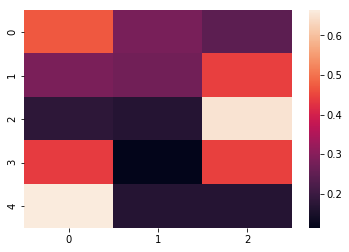

In [26]:
import seaborn as sns

doc_topics = [lda.get_document_topics(doc) for doc in corpus]
doc_topic_probabilities = []
for document in doc_topics: 
    single_document = []
    for topic, probablity in document:
        single_document.append(probablity)
    doc_topic_probabilities.append(single_document)
docs_topics = pd.DataFrame(doc_topic_probabilities)
sns.heatmap(docs_topics)

#  
### 12. Fit an LDA model with sklearn

Sklearn's LDA model is in the decomposition submodule:

```python
from sklearn.decomposition import LatentDirichletAllocation
```

One of the greatest benefits of the sklearn implementation is that it comes with the familiar `.fit()`, `.transform()` and `.fit_transform()` methods.

**12.1 Initialize and fit an sklearn LDA with `n_topics=3` on our output from the CountVectorizer.**

In [27]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=3)
lda.fit(X)

/Users/edoardo/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=3, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

**12.2 Print out the topic-word distributions using the `.components_` attribute.**

Each row of this matrix represents a topic, and the columns are the words. (These are not probabilities).

In [28]:
lda.components_

array([[0.46971341, 1.26288388, 0.49696078, 2.07143678, 0.47291834,
        1.233237  , 0.48247074, 2.09905103, 0.45012415, 1.26867008,
        2.04455486, 0.45068844, 0.47801102, 1.24721563, 0.45806614,
        1.30940493, 0.45549244, 1.26430079, 0.47857205, 0.43529189,
        1.24821895, 0.484328  , 0.45504953, 0.47743951, 0.44544044],
       [1.26772382, 0.45770218, 0.4559101 , 1.24437564, 0.4569616 ,
        0.47455089, 1.26998316, 0.43962837, 0.47852031, 0.47098508,
        1.24368237, 2.07859326, 0.42924665, 0.45257895, 1.28209132,
        0.45885923, 1.26593826, 0.46246446, 1.27224465, 1.25936061,
        0.45283364, 1.25597203, 0.4791865 , 0.45675002, 1.24414888],
       [0.48859491, 0.44336546, 1.29073104, 0.44344958, 1.29600982,
        0.48067852, 1.25598652, 0.44833596, 1.26962463, 0.46370642,
        0.46592273, 1.26754487, 1.27282282, 0.43362257, 0.49400114,
        0.47509618, 0.45521434, 1.27073324, 0.46195243, 0.50348905,
        0.47195326, 0.4787352 , 1.26985607, 1.

**12.3 Use the `.transform()` method to convert the matrix into the topic scores.**

These are the document-topic distributions.

In [29]:
lda.transform(X)

array([[0.91389499, 0.04392223, 0.04218277],
       [0.04856835, 0.90136096, 0.05007069],
       [0.03434376, 0.03547342, 0.93018282],
       [0.90115504, 0.04864417, 0.05020079],
       [0.054566  , 0.89557041, 0.0498636 ]])

### 13. Further steps

This has been a very basic example.  LDA typically doesn't perform well on very small datasets.  You should try to see how it behaves on your own using a larger text dataset.  Keep in mind: finding the optimal number of topics can be tricky and subjective.

**Generally, you should consider:**
- How well topics are applied to documents overall
- The strength of topics overall, to all documents
- Improving preprocessing such as stopword removal
- Building a nice web interface to explore your documents (see: [LDAExplorer](https://github.com/dyerrington/LDAExplorer), and [pyLDAvis](https://github.com/bmabey/pyLDAvis/blob/master/README.rst))

These general guidelines should help you tune your hyperparameter **K** for number of topics.